# Settings

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

def confusion2score(confusion):
    tp, fn, fp, tn = confusion.ravel()
    if tp == None:
        tp = 0
    if fn == None:
        fn = 0
    if fp == None:
        fp = 0
    if tn == None:
        tn = 0
    acc = (tp + tn) / (tp + fn + fp + tn)
    if (tp+fp) == 0:
        pre=0
    else:
        pre = tp / (tp + fp)
    if (tp+fn) == 0:
        rec=0
    else:
        rec = tp / (tp + fn)
    if (2*tp+fp+fn) == 0:
        f1=0
    else:
        f1  = (2 * tp) / (2*tp + fp + fn)
    return (acc, pre, rec, f1)

import spacy
from bs4 import BeautifulSoup

spacy_en = spacy.load('en')
def tokenizer(text):
    soup = BeautifulSoup(text)
    clean_txt = soup.get_text()
    words = []
    for tok in spacy_en.tokenizer(clean_txt):
        if tok.text not in "[],.();:<>{}|*-~":
            words.append(tok.lemma_)
    return " ".join(words)

# Random Forest

## without feature engineering

In [2]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values
del train_df, test_df

vect = CountVectorizer(min_df=10, ngram_range=(1,3))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=2019)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 2794
X_train shape:  (8000, 2794)
X_test shape:  (2717, 2794)
Confusion Matrix: 
[[  13  315]
 [   1 2388]]
scores:  (0.8836952521163047, 0.9285714285714286, 0.039634146341463415, 0.07602339181286549)
AUC:  0.5196077805796895


In [3]:
def create_model_pred(train_df, test_df, n_gram, min_df, n_estimators, max_depth):
    X_train = [tokenizer(text) for text in train_df.body.values]
    X_test  = [tokenizer(text) for text in test_df.body.values]
    y_train = train_df.causal_flag.values
    y_test  = test_df.causal_flag.values
    
    vect = CountVectorizer(min_df=min_df, ngram_range=(1,n_gram))
    vect.fit(X_train)
    X_train = vect.transform(X_train)
    X_test  = vect.transform(X_test)
    
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=2019)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    confusion = confusion_matrix(y_test, y_pred)
    scores    = confusion2score(confusion)
    return scores

train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]
train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

create_model_pred(train_df, test_df, n_gram=3, min_df=10, n_estimators=100, max_depth=5)

(0.9366948840633051,
 0.7910447761194029,
 0.6463414634146342,
 0.7114093959731543)

## with feature engineering

### without oversampling

In [4]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values
del train_df, test_df

vect = CountVectorizer(min_df=10, ngram_range=(1,3))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=2019)
rf_model.fit(X_train, y_train)

fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names)
use_cols = fi_df[fi_df[0] > 0.0].index.values

print('# of use columns: ', len(use_cols))
X_train = X_train[use_cols]
X_test  = X_test[use_cols]

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=2019)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 2794
X_train shape:  (8000, 2794)
X_test shape:  (2717, 2794)
# of use columns:  646
Confusion Matrix: 
[[  89  239]
 [   4 2385]]
scores:  (0.9105631210894369, 0.956989247311828, 0.27134146341463417, 0.42280285035629456)
AUC:  0.634833561343148


### with oversampling

In [5]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]

train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values
del train_df, test_df

vect = CountVectorizer(min_df=10, ngram_range=(1,3))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=2019)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 6407
X_train shape:  (14018, 6407)
X_test shape:  (2717, 6407)
Confusion Matrix: 
[[ 212  116]
 [  56 2333]]
scores:  (0.9366948840633051, 0.7910447761194029, 0.6463414634146342, 0.7114093959731543)
AUC:  0.8114503466089494


In [6]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]
train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values
del train_df, test_df

vect = CountVectorizer(min_df=10, ngram_range=(1,3))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=2019)
rf_model.fit(X_train, y_train)

fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names)
use_cols = fi_df[fi_df[0] > 0.0].index.values

print('# of use columns: ', len(use_cols))
X_train = X_train[use_cols]
X_test  = X_test[use_cols]

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=2019)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 6407
X_train shape:  (14018, 6407)
X_test shape:  (2717, 6407)
# of use columns:  740
Confusion Matrix: 
[[ 241   87]
 [  35 2354]]
scores:  (0.9550975340449025, 0.8731884057971014, 0.7347560975609756, 0.7980132450331126)
AUC:  0.8600528080940081


In [7]:
def create_model_pred2(train_df, test_df, n_gram, min_df, n_estimators, max_depth, feat_eng=False):
    X_train = [tokenizer(text) for text in train_df.body.values]
    X_test  = [tokenizer(text) for text in test_df.body.values]
    y_train = train_df.causal_flag.values
    y_test  = test_df.causal_flag.values
    
    vect = CountVectorizer(min_df=min_df, ngram_range=(1,n_gram))
    vect.fit(X_train)
    X_train = vect.transform(X_train)
    X_test  = vect.transform(X_test)
    
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=2019)
    rf_model.fit(X_train, y_train)
    if feat_eng:
        feature_names = vect.get_feature_names()
        X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
        X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)
        fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names)
        use_cols = fi_df[fi_df[0] > 0.0].index.values
        X_train = X_train[use_cols]
        X_test  = X_test[use_cols]
        rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=2019)
        rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    confusion = confusion_matrix(y_test, y_pred)
    scores    = confusion2score(confusion)
    return scores

train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]
train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

create_model_pred(train_df, test_df, n_gram=3, min_df=10, n_estimators=100, max_depth=5, feat_eng=True)

(0.9550975340449025,
 0.8731884057971014,
 0.7347560975609756,
 0.7980132450331126)

# Hyperparameter Search by Optuna

## without feature engineering

### without oversampling

In [4]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

def objective(trial):
    n_gram       = trial.suggest_int('n_gram', 1, 5)
    min_df       = int(trial.suggest_discrete_uniform('min_df', 5, 20, 5))
    n_estimators = int(trial.suggest_discrete_uniform('n_estimators', 100, 1000, 300))
    max_depth    = trial.suggest_int('max_depth', 5, 10)
    
    scores = create_model_pred(train_df, test_df, n_gram, min_df, n_estimators, max_depth)
    
    return 1 - scores[3]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2019-08-04 12:35:43,244] Finished trial#0 resulted in value: 0.5158371040723981. Current best value is 0.5158371040723981 with parameters: {'n_gram': 3, 'min_df': 20.0, 'n_estimators': 1000.0, 'max_depth': 8}.
[I 2019-08-04 12:35:48,112] Finished trial#1 resulted in value: 0.9017341040462428. Current best value is 0.5158371040723981 with parameters: {'n_gram': 3, 'min_df': 20.0, 'n_estimators': 1000.0, 'max_depth': 8}.
[I 2019-08-04 12:35:52,697] Finished trial#2 resulted in value: 0.6274509803921569. Current best value is 0.5158371040723981 with parameters: {'n_gram': 3, 'min_df': 20.0, 'n_estimators': 1000.0, 'max_depth': 8}.
[I 2019-08-04 12:35:57,118] Finished trial#3 resulted in value: 0.6836734693877551. Current best value is 0.5158371040723981 with parameters: {'n_gram': 3, 'min_df': 20.0, 'n_estimators': 1000.0, 'max_depth': 8}.
[I 2019-08-04 12:36:00,888] Finished trial#4 resulted in value: 0.543778801843318. Current best value is 0.5158371040723981 with parameters: {'n_gra

In [5]:
print('best parameters: ', study.best_params)
print('best f1 score: {}'.format(1-study.best_value))

best parameters:  {'n_gram': 2, 'min_df': 20.0, 'n_estimators': 1000.0, 'max_depth': 10}
best f1 score: 0.5283842794759825


In [6]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values

vect = CountVectorizer(min_df=20, ngram_range=(1,2))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

rf_model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=2019)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 1156
X_train shape:  (8000, 1156)
X_test shape:  (2717, 1156)
Confusion Matrix: 
[[ 121  207]
 [   9 2380]]
scores:  (0.9205005520794994, 0.9307692307692308, 0.36890243902439024, 0.5283842794759825)
AUC:  0.6825675861928147


findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.


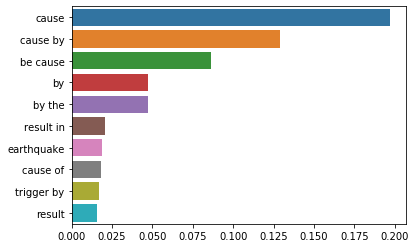

In [8]:
fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names).sort_values(0, ascending=False)

plt.figure()
sns.barplot(x=fi_df.head(10)[0].values,y=fi_df.head(10).index.values, data=fi_df.head(10))
plt.show()

### with oversampling

In [9]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]
train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

def objective(trial):
    n_gram       = trial.suggest_int('n_gram', 1, 5)
    min_df       = int(trial.suggest_discrete_uniform('min_df', 5, 20, 5))
    n_estimators = int(trial.suggest_discrete_uniform('n_estimators', 100, 1000, 300))
    max_depth    = trial.suggest_int('max_depth', 5, 10)
    
    scores = create_model_pred(train_df, test_df, n_gram, min_df, n_estimators, max_depth)
    
    return 1 - scores[3]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2019-08-04 12:47:39,983] Finished trial#0 resulted in value: 0.25. Current best value is 0.25 with parameters: {'n_gram': 2, 'min_df': 20.0, 'n_estimators': 400.0, 'max_depth': 5}.
[I 2019-08-04 12:47:49,358] Finished trial#1 resulted in value: 0.24918032786885247. Current best value is 0.24918032786885247 with parameters: {'n_gram': 5, 'min_df': 15.0, 'n_estimators': 1000.0, 'max_depth': 6}.
[I 2019-08-04 12:47:56,140] Finished trial#2 resulted in value: 0.25037037037037035. Current best value is 0.24918032786885247 with parameters: {'n_gram': 5, 'min_df': 15.0, 'n_estimators': 1000.0, 'max_depth': 6}.
[I 2019-08-04 12:48:02,725] Finished trial#3 resulted in value: 0.2831737346101231. Current best value is 0.24918032786885247 with parameters: {'n_gram': 5, 'min_df': 15.0, 'n_estimators': 1000.0, 'max_depth': 6}.
[I 2019-08-04 12:48:09,332] Finished trial#4 resulted in value: 0.25. Current best value is 0.24918032786885247 with parameters: {'n_gram': 5, 'min_df': 15.0, 'n_estimators

In [10]:
print('best parameters: ', study.best_params)
print('best f1 score: {}'.format(1-study.best_value))

best parameters:  {'n_gram': 5, 'min_df': 15.0, 'n_estimators': 400.0, 'max_depth': 10}
best f1 score: 0.8221859706362153


In [12]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]
train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values

vect = CountVectorizer(min_df=15, ngram_range=(1,5))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

rf_model = RandomForestClassifier(n_estimators=400, max_depth=10, random_state=2019)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 4137
X_train shape:  (14018, 4137)
X_test shape:  (2717, 4137)
Confusion Matrix: 
[[ 252   76]
 [  33 2356]]
scores:  (0.9598822230401178, 0.8842105263157894, 0.7682926829268293, 0.8221859706362153)
AUC:  0.8772396859590196


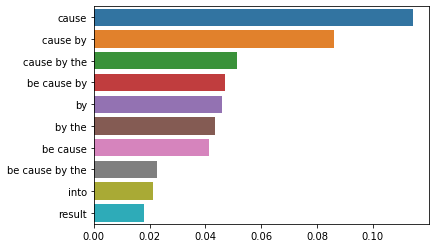

In [13]:
fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names).sort_values(0, ascending=False)

plt.figure()
sns.barplot(x=fi_df.head(10)[0].values,y=fi_df.head(10).index.values, data=fi_df.head(10))
plt.show()

## with feature engineering

### without oversampling

In [8]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

def objective(trial):
    n_gram       = trial.suggest_int('n_gram', 1, 5)
    min_df       = int(trial.suggest_discrete_uniform('min_df', 5, 20, 5))
    n_estimators = int(trial.suggest_discrete_uniform('n_estimators', 100, 1000, 300))
    max_depth    = trial.suggest_int('max_depth', 5, 10)
    feat_eng     = trial.suggest_categorical('feat_eng', [True, False])
    
    scores = create_model_pred2(train_df, test_df, n_gram, min_df, n_estimators, max_depth, feat_eng)
    
    return 1 - scores[3]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2019-07-30 15:58:37,621] Finished trial#0 resulted in value: 0.8032786885245902. Current best value is 0.8032786885245902 with parameters: {'n_gram': 5, 'min_df': 10.0, 'n_estimators': 700.0, 'max_depth': 5, 'feat_eng': False}.
[I 2019-07-30 15:58:49,102] Finished trial#1 resulted in value: 0.6733668341708543. Current best value is 0.6733668341708543 with parameters: {'n_gram': 3, 'min_df': 15.0, 'n_estimators': 700.0, 'max_depth': 5, 'feat_eng': True}.
[I 2019-07-30 15:59:06,472] Finished trial#2 resulted in value: 0.6485148514851485. Current best value is 0.6485148514851485 with parameters: {'n_gram': 4, 'min_df': 15.0, 'n_estimators': 1000.0, 'max_depth': 6, 'feat_eng': True}.
[I 2019-07-30 15:59:11,993] Finished trial#3 resulted in value: 0.5033557046979866. Current best value is 0.5033557046979866 with parameters: {'n_gram': 3, 'min_df': 20.0, 'n_estimators': 100.0, 'max_depth': 8, 'feat_eng': True}.
[I 2019-07-30 15:59:17,258] Finished trial#4 resulted in value: 0.764705882352

### best parameters

In [9]:
print('best parameters: ', study.best_params)
print('best f1 score: {}'.format(1-study.best_value))

best parameters:  {'n_gram': 2, 'min_df': 5.0, 'n_estimators': 100.0, 'max_depth': 10, 'feat_eng': True}
best f1 score: 0.5295404814004376


In [12]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values

vect = CountVectorizer(min_df=5, ngram_range=(1,2))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=2019)
rf_model.fit(X_train, y_train)

fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names)
use_cols = fi_df[fi_df[0] > 0.0].index.values

print('# of use columns: ', len(use_cols))
X_train = X_train[use_cols]
X_test  = X_test[use_cols]

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=2019)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 5846
X_train shape:  (8000, 5846)
X_test shape:  (2717, 5846)
# of use columns:  1560
Confusion Matrix: 
[[ 121  207]
 [   8 2381]]
scores:  (0.9208686050791314, 0.937984496124031, 0.36890243902439024, 0.5295404814004376)
AUC:  0.6827768787838568


findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.


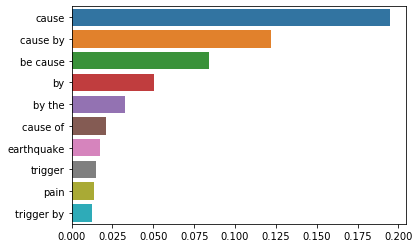

In [14]:
fi_df = pd.DataFrame(rf_model.feature_importances_, index=use_cols).sort_values(0, ascending=False)

plt.figure()
sns.barplot(x=fi_df.head(10)[0].values,y=fi_df.head(10).index.values, data=fi_df.head(10))
plt.show()

### with oversampling

In [15]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]
train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

def objective(trial):
    n_gram       = trial.suggest_int('n_gram', 1, 5)
    min_df       = int(trial.suggest_discrete_uniform('min_df', 5, 20, 5))
    n_estimators = int(trial.suggest_discrete_uniform('n_estimators', 100, 1000, 300))
    max_depth    = trial.suggest_int('max_depth', 5, 10)
    feat_eng     = trial.suggest_categorical('feat_eng', [True, False])
    
    scores = create_model_pred2(train_df, test_df, n_gram, min_df, n_estimators, max_depth, feat_eng)
    
    return 1 - scores[3]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

print('best parameters: ', study.best_params)
print('best f1 score: {}'.format(1-study.best_value))

[I 2019-07-30 16:29:25,615] Finished trial#0 resulted in value: 0.2383720930232558. Current best value is 0.2383720930232558 with parameters: {'n_gram': 1, 'min_df': 15.0, 'n_estimators': 400.0, 'max_depth': 9, 'feat_eng': True}.
[I 2019-07-30 16:29:33,810] Finished trial#1 resulted in value: 0.24473257698541329. Current best value is 0.2383720930232558 with parameters: {'n_gram': 1, 'min_df': 15.0, 'n_estimators': 400.0, 'max_depth': 9, 'feat_eng': True}.
[I 2019-07-30 16:29:42,258] Finished trial#2 resulted in value: 0.22038980509745132. Current best value is 0.22038980509745132 with parameters: {'n_gram': 1, 'min_df': 10.0, 'n_estimators': 1000.0, 'max_depth': 10, 'feat_eng': False}.
[I 2019-07-30 16:30:08,503] Finished trial#3 resulted in value: 0.2185430463576159. Current best value is 0.2185430463576159 with parameters: {'n_gram': 4, 'min_df': 5.0, 'n_estimators': 400.0, 'max_depth': 7, 'feat_eng': True}.
[I 2019-07-30 16:30:33,655] Finished trial#4 resulted in value: 0.186602870

best parameters:  {'n_gram': 3, 'min_df': 15.0, 'n_estimators': 100.0, 'max_depth': 10, 'feat_eng': True}
best f1 score: 0.8256578947368421


In [16]:
train_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/train_original.tsv', sep='\t')
train_df = train_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in train_df.relation.values]).drop(['relation', 'comment'], axis=1)
train_df.body = [text.replace('"', '') for text in train_df.body.values]
test_df = pd.read_csv('/home/b2018yniki/data/semeval2010task8/test_original.tsv', sep='\t')
test_df = test_df.assign(causal_flag = [0 if 'Cause-Effect' in relation else 1 for relation in test_df.relation.values]).drop(['relation', 'comment'], axis=1)
test_df.body = [text.replace('"', '') for text in test_df.body.values]

posi_df = train_df[train_df.causal_flag==0]
nega_df = train_df[train_df.causal_flag==1]
train_df = pd.concat([posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, posi_df, nega_df])
del posi_df, nega_df

X_train = [tokenizer(text) for text in train_df.body.values]
X_test  = [tokenizer(text) for text in test_df.body.values]
y_train = train_df.causal_flag.values
y_test  = test_df.causal_flag.values

vect = CountVectorizer(min_df=15, ngram_range=(1,3))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=2019)
rf_model.fit(X_train, y_train)

fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names)
use_cols = fi_df[fi_df[0] > 0.0].index.values

print('# of use columns: ', len(use_cols))
X_train = X_train[use_cols]
X_test  = X_test[use_cols]

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=2019)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 3991
X_train shape:  (14018, 3991)
X_test shape:  (2717, 3991)
# of use columns:  1834
Confusion Matrix: 
[[ 251   77]
 [  29 2360]]
scores:  (0.9609863820390137, 0.8964285714285715, 0.7652439024390244, 0.8256578947368421)
AUC:  0.876552466079286


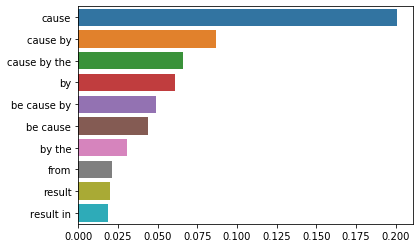

In [17]:
fi_df = pd.DataFrame(rf_model.feature_importances_, index=use_cols).sort_values(0, ascending=False)

plt.figure()
sns.barplot(x=fi_df.head(10)[0].values,y=fi_df.head(10).index.values, data=fi_df.head(10))
plt.show()